# Imports

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Data Loading


Monthly data from 1991 to 2008 

In [15]:
df = pd.read_csv('./AusAntidiabeticDrug.csv')
df.head()

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [16]:
df.tail()

,ds,y
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510
203,2008-06-01,19.431740


In [17]:
df.isnull().sum()

ds    0
y     0
dtype: int64

In [18]:
df.shape

(204, 2)

In [19]:
df['ds'] = pd.to_datetime(df['ds'])

In [20]:
df.ds.describe()

count                              204
mean     1999-12-16 10:49:24.705882368
min                1991-07-01 00:00:00
25%                1995-09-23 12:00:00
50%                1999-12-16 12:00:00
75%                2004-03-08 18:00:00
max                2008-06-01 00:00:00
Name: ds, dtype: object

In [21]:
df.describe()

,ds,y
count,204,204.000000
mean,1999-12-16 10:49:24.705882368,10.694430
min,1991-07-01 00:00:00,2.814520
25%,1995-09-23 12:00:00,5.844095
50%,1999-12-16 12:00:00,9.319345
75%,2004-03-08 18:00:00,14.289964
max,2008-06-01 00:00:00,29.665356
std,NaN,5.956998


# Visualization

## Data plotting

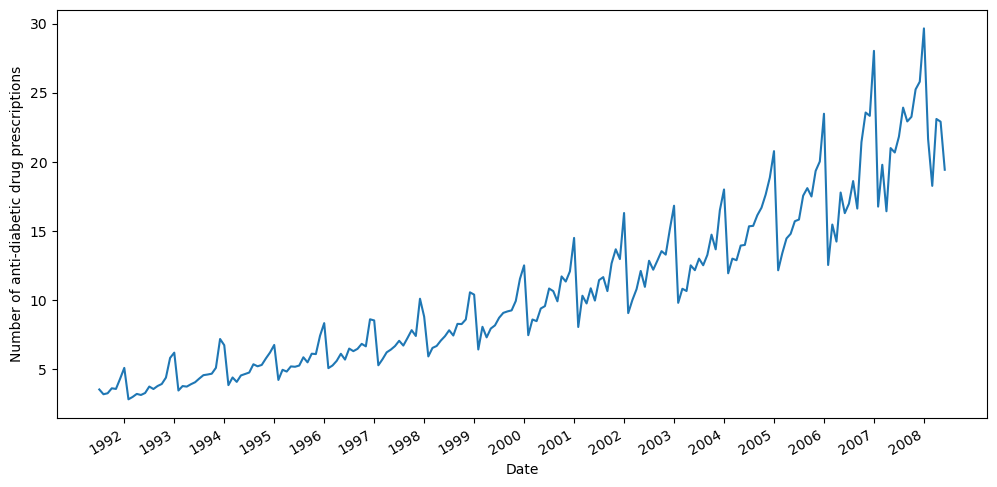

In [22]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(df['y'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
#ax.axvspan(80, 83, color='#808080', alpha=0.2)
plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
#plt.tight_layout()



## Decomposition

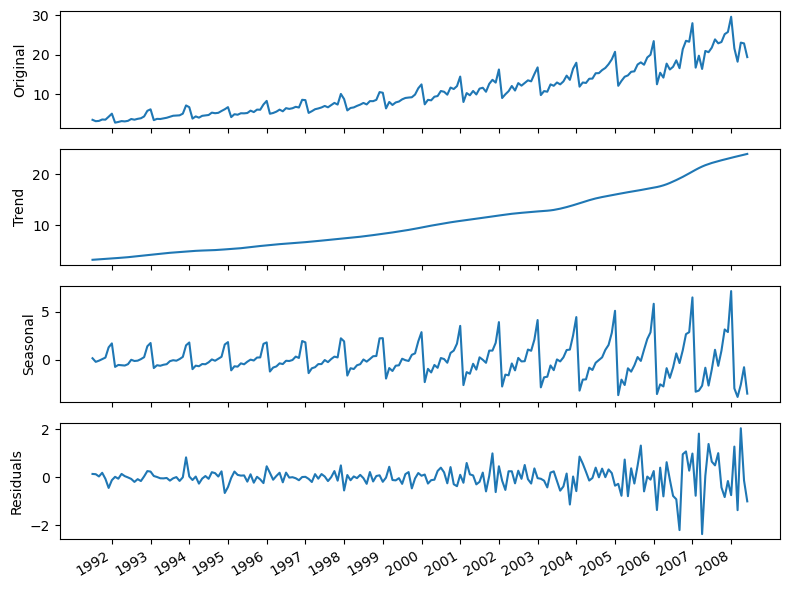

In [23]:
decomposition = STL(df.y, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Original')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()



# Stationarity Test

In [24]:
df.set_index('ds', inplace=True)

In [25]:
def test_stationarity(df):
    
    # Perform ADF test
    ADF_result = adfuller(df)
    
    # Print ADF statistic and p-value
    print(f'ADF Statistic: {ADF_result[0]}')
    print(f'p-value: {ADF_result[1]}')
    
    # Compare p-value to significance level (e.g., 0.05)
    if ADF_result[1] < 0.05:
        print("Result: Data is stationary (reject the null hypothesis)")
    else:
        print("Result: Data is non-stationary (fail to reject the null hypothesis)")
    
    # Return ADF test result
    return ADF_result




In [26]:
ADF_result = test_stationarity(df)

ADF Statistic: 3.145185689306745
p-value: 1.0
Result: Data is non-stationary (fail to reject the null hypothesis)


In [27]:
# Perform differencing with n=1
df_diff = df.diff(periods=1)

# Drop the NaN values resulting from differencing
df_diff.dropna(inplace=True)

In [28]:
# Perform differencing with n=1
df_diff = df_diff.diff(periods=1)

# Drop the NaN values resulting from differencing
df_diff.dropna(inplace=True)

In [29]:
ADF_result = test_stationarity(df_diff)

ADF Statistic: -10.292304706517333
p-value: 3.543916358529137e-18
Result: Data is stationary (reject the null hypothesis)


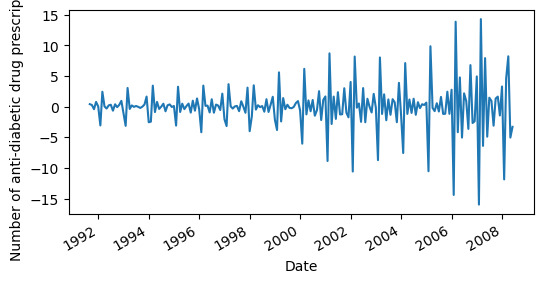

In [30]:
fig, ax = plt.subplots(figsize=(6,3))

ax.plot(df_diff['y'])
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')



fig.autofmt_xdate()
#plt.tight_layout()

## ACF

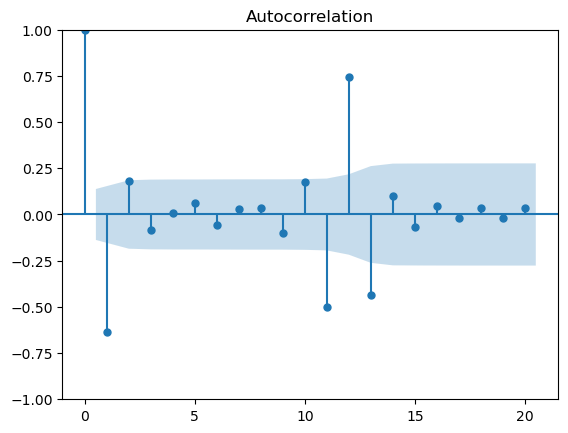

In [31]:
plot_acf(df_diff, lags=20);


Not a random walk (There's an autocorrelation) 

Not MA , It is sinusoidal 

## PACF

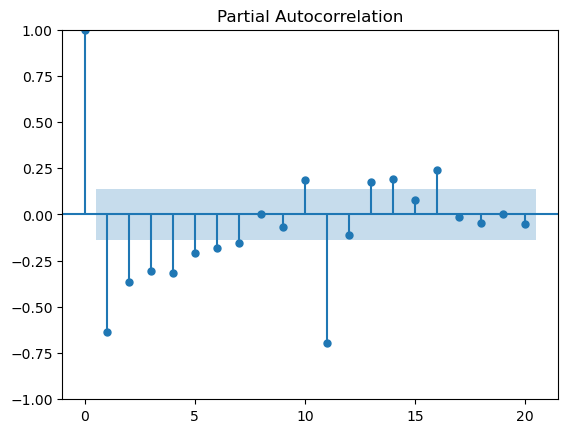

In [32]:
plot_pacf(df_diff, lags=20);

* ***Not AR , pacf is sinusoidal***

* ***It's An ARMA Process(ARMA, ARIMA, SARIMA)***

* ***It isn't stationary , to avoid undo transformation we will use Integration (d) parameter***

### It has seasonal component ,so  ***SARIMA*** is the best choice 

# SARIMA

Redo transformation to determine d and I 

In [33]:
ADF_result = test_stationarity(df)

ADF Statistic: 3.145185689306745
p-value: 1.0
Result: Data is non-stationary (fail to reject the null hypothesis)


### ***Removing Trend***

In [34]:
# Perform differencing with n=1
df_diff = df.diff(periods=1)

# Drop the NaN values resulting from differencing
df_diff.dropna(inplace=True)

In [35]:
ADF_result = test_stationarity(df_diff)

ADF Statistic: -2.4951721474497757
p-value: 0.11665341686467895
Result: Data is non-stationary (fail to reject the null hypothesis)


### ***Removing Seasonality (m = 12)***

SARIMA(p,1,q)(P,1,Q)12

m = 12 as it's a yearly seasonality and the data is recorded monthly

In [36]:
# Perform differencing with n=1
df_diff = df_diff.diff(periods=12)

# Drop the NaN values resulting from differencing
df_diff.dropna(inplace=True)

In [37]:
ADF_result = test_stationarity(df_diff)

ADF Statistic: -4.78343959564798
p-value: 5.849508608803529e-05
Result: Data is stationary (reject the null hypothesis)


* ***D = 1, Q = 11*** as we took one difference and one seasonal difference

# Train-Test Split


We want to predict 3 years ( 36 months )

In [38]:
df = pd.read_csv('./AusAntidiabeticDrug.csv')

In [39]:
train = df.y[:-36]
test = df.y[-36:]

print(len(test))

36


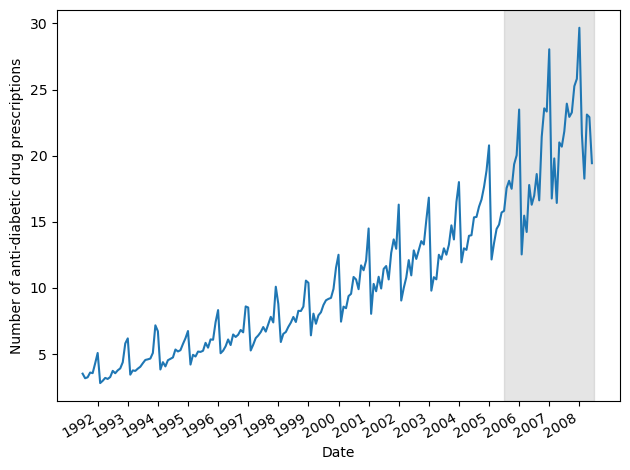

In [40]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))

fig.autofmt_xdate()
plt.tight_layout()

# SARIMA(p,1,q)(P,1,Q)12 Model 

In [41]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Calculate AIC for all combinations of (p,d,q) , (P,D,Q) , m
# s = m --> the frequency

def optimize_SARIMAX(endog: Union[pd.Series, list, pd.DataFrame], exog: Union[pd.Series, list, pd.DataFrame], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [42]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12

In [43]:
#order_list

In [44]:
SARIMA_result_df = optimize_SARIMAX(train, None, order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951097
1,"(2, 4, 1, 3)",271.216264
2,"(3, 3, 1, 3)",271.428641
3,"(4, 1, 1, 3)",272.145292
4,"(0, 4, 1, 3)",272.152380
...,...,...
620,"(0, 0, 4, 4)",353.028183
621,"(0, 0, 2, 4)",353.257113
622,"(0, 0, 0, 1)",354.751719
623,"(0, 0, 1, 0)",357.173706


In [56]:
SARIMA_model = SARIMAX(train, order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(2, 1, 3)x(1, 1, 3, 12)   Log Likelihood                -128.117
Date:                            Wed, 05 Jun 2024   AIC                            276.234
Time:                                    22:15:12   BIC                            306.669
Sample:                                         0   HQIC                           288.596
                                            - 168                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1314      0.055    -20.679      0.000      -1.239      -1.024
ar.L2         -0.9659      0.064   

## Residuals

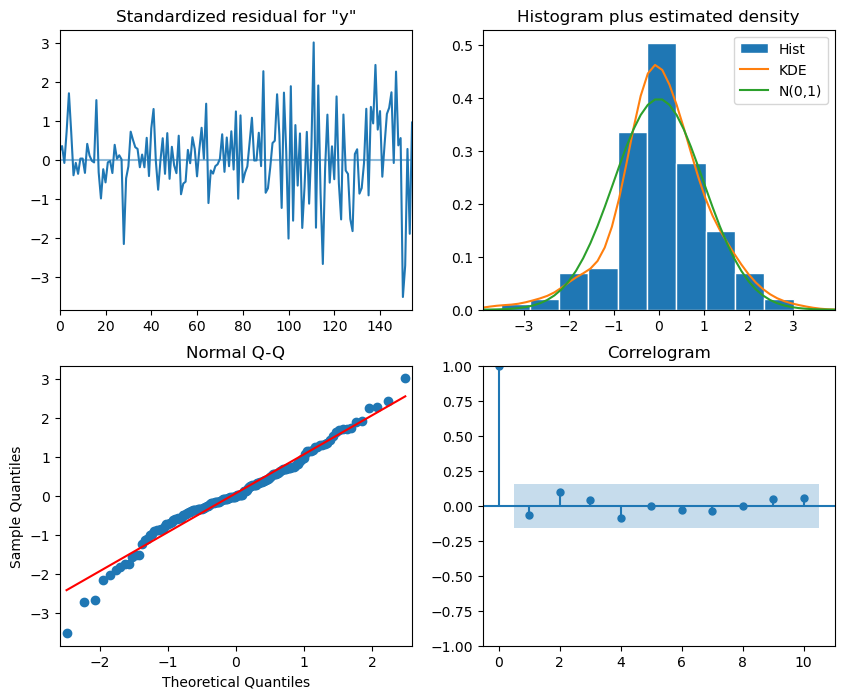

In [57]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

# Forecasting

In [60]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['y'][i-window:i].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'SARIMA':
        pred_SARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df['y'][:i], order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMA.extend(oos_pred)
            
        return pred_SARIMA

In [70]:
df

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [71]:
# test set
pred_df = df[-36:]

pred_df

,ds,y
168,2005-07-01,15.829550
169,2005-08-01,17.554701
170,2005-09-01,18.100864
171,2005-10-01,17.496668
172,2005-11-01,19.347265
173,2005-12-01,20.031291
174,2006-01-01,23.486694
175,2006-02-01,12.536987
176,2006-03-01,15.467018
177,2006-04-01,14.233539


### Naive Model (Last Saeson)

In [76]:
TRAIN_LEN = 168
HORIZON = 36 # Number of monthes to forcast
WINDOW = 12

# Make sure the 'rolling_forecast' function returns values compatible with the DataFrame index
forecast_values = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'last_season')

# Check if the length of forecast_values matches the length of the DataFrame index
if len(forecast_values) == len(df[-36:]):
    # Assign forecasted values to the DataFrame column
    pred_df['last_season'] = forecast_values
else:
    print("Length of forecast values does not match the length of the DataFrame index.")


In [79]:
pred_df['SARIMA'] = rolling_forecast(df, TRAIN_LEN, HORIZON, WINDOW, 'SARIMA')

pred_df

,ds,y,last_season,SARIMA
168,2005-07-01,15.829550,15.339097,16.750339
169,2005-08-01,17.554701,15.370764,16.686429
170,2005-09-01,18.100864,16.142005,17.188924
171,2005-10-01,17.496668,16.685754,18.089939
172,2005-11-01,19.347265,17.636728,18.660558
173,2005-12-01,20.031291,18.869325,19.947848
174,2006-01-01,23.486694,20.778723,22.078767
175,2006-02-01,12.536987,12.154552,13.744778
176,2006-03-01,15.467018,13.402392,15.083579
177,2006-04-01,14.233539,14.459239,15.657409


### Result Visualization

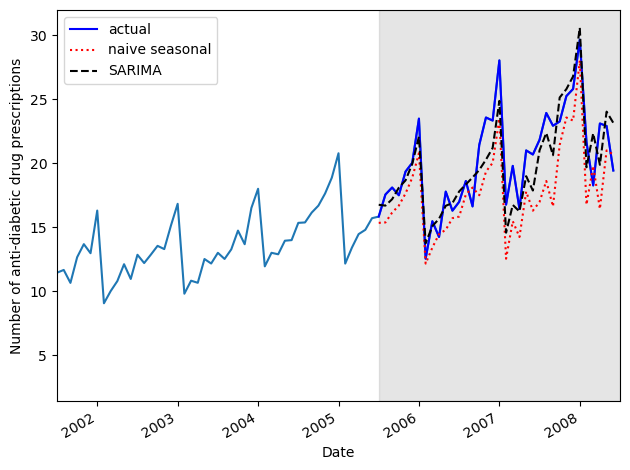

In [80]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.plot(pred_df.y, 'b-', label='actual')
ax.plot(pred_df.last_season, 'r:', label='naive seasonal')
ax.plot(pred_df.SARIMA, 'k--', label='SARIMA')
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')
ax.axvspan(168, 204, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
plt.xlim(120, 204)

fig.autofmt_xdate()
plt.tight_layout()

# Evaluation

In [81]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [82]:
mape_naive_seasonal = mape(pred_df.y, pred_df.last_season)
mape_SARIMA = mape(pred_df.y, pred_df.SARIMA)

print(mape_naive_seasonal, mape_SARIMA)

12.686561923100614 7.8976257150626825


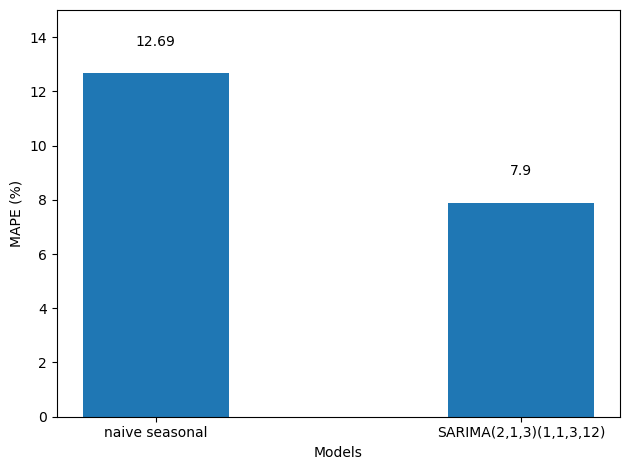

In [83]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'SARIMA(2,1,3)(1,1,3,12)']
y = [mape_naive_seasonal, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()